
## DESCRIPTION

This notebook plots the results of the GLMM with the lowest AIC.

Best model is model27.

We use R to produce the plots

***
### SETUP

Load the setup script

In [54]:
from utils.common_setup import *

Import the cleaned dataset

In [55]:
data_folder = os.path.join(os.getcwd(), '..', 'data')
data = pd.read_csv(os.path.join(data_folder, 'clean_data.csv'))

Import the best model

In [56]:
project_root = os.path.dirname(os.getcwd())
output_dir = os.path.join(project_root, 'outputs')
filepath = os.path.join(output_dir, "GLMM_best_model.joblib")

model = load_model(filepath = filepath)

Activate R interface

In [58]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

# pandas <-> R conversion
pandas2ri.activate()

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Pass the fitted model and the data from pymer4 to R using rpy2

In [59]:
# Python model to R object
#ro.globalenv['model'] = model.model_obj

# Python data to R object
ro.globalenv['data'] = pandas2ri.py2rpy(data)

Load R libraries and random effects as factors

In [60]:
%%R
library(lme4)
library(ggplot2)
library(ggpubr)
library(performance)
library(viridis)

data$region <- as.factor(data$region)
data$operation_id <- as.factor(data$operation_id)
data$season <- as.factor(data$season)
data$death_next_season <- as.integer(ifelse(data$death_next_season == FALSE, 0, 1))

Scale variables to refit best model in R

In [61]:
%%R
data$ndvi_average_sc <- scale(data$ndvi_average)
data$o3_average_sc <- scale(data$o3_average)
data$wspd_average_sc <- scale(data$wspd_average_og)

Import the best model directly in R

In [9]:
%%R
file_path1 <- file.path("..", "outputs", "GLMM_best_model.rds")
file_path2 <- file.path("..", "outputs", "GLMM_best_model_refit.rds")

model <- readRDS(file_path1)
refit_model <- readRDS(file_path2)

Refit the main model in R for better UI.

Just do it once.

Takes about 5 minutes.

In [62]:
%%R
## Formula
#form <- "death_next_season ~ ndvi_average_sc * o3_average_sc * wspd_average_sc + (o3_average_sc|operation_id)"
#
## Fit
#model <- glmer(
#    formula = form,
#    family = "binomial",
#    data = data
#)
#
## Save the output
#filename <- file.path("..", "outputs", "GLMM_best_model.rds")
#saveRDS(model, filename)

### PLOT MODEL

#### Inspect coefficients

In [63]:
%%R
fixef(model)

                                  (Intercept) 
                                  -0.14855303 
                              ndvi_average_sc 
                                  -0.41253581 
                                o3_average_sc 
                                   1.24337780 
                              wspd_average_sc 
                                  -0.12554948 
                ndvi_average_sc:o3_average_sc 
                                  -0.10550911 
              ndvi_average_sc:wspd_average_sc 
                                  -0.02645340 
                o3_average_sc:wspd_average_sc 
                                   0.03932302 
ndvi_average_sc:o3_average_sc:wspd_average_sc 
                                  -0.06802618 


#### O3 average

Generate predictions for O3

In [64]:
%%R
# New data for predictions
new_data <- data.frame(
    o3_average_sc = seq(min(data$o3_average_sc), max(data$o3_average_sc), length.out=100),
    ndvi_average_sc = mean(data$ndvi_average_sc),
    wspd_average_sc = mean(data$wspd_average_sc)
)

# Predictions
preds <- predict(
    model,
    new_data,
    re.form=NA,
    se.fit=TRUE
)

new_data$fit <- preds$fit
new_data$se <- preds$se.fit
new_data$ci_lower <- new_data$fit - 1.96 * new_data$se
new_data$ci_upper <- new_data$fit + 1.96 * new_data$se

In addition: Warning message:
In predict.merMod(model, new_data, re.form = NA, se.fit = TRUE) :
  se.fit computation uses an approximation to estimate the sampling distribution of the parameters


Plot predictions

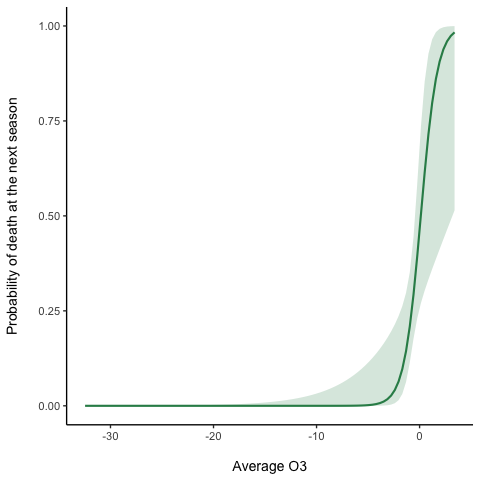

In [65]:
%%R
p <- ggplot(new_data, aes(x=o3_average_sc, y=plogis(fit))) +
        geom_line(color="seagreen", linewidth = 1) +
        geom_ribbon(aes(ymin=plogis(ci_lower), ymax=plogis(ci_upper)), alpha=0.2, fill="seagreen") +
        scale_y_continuous(breaks = seq(0,1,0.25), limits = c(0,1)) +
        labs(x="\nAverage O3", y="Probability of death at the next season\n") +
        theme_classic(base_size = 14) +
        theme(panel.grid = element_blank())
p

#### Wind speed

In [66]:
%%R
# New data for predictions
new_data <- data.frame(
    wspd_average_sc = seq(
        min(data$wspd_average_sc),
        max(data$wspd_average_sc),
        length.out = 100
    ),
    o3_average_sc = mean(data$o3_average_sc),
    ndvi_average_sc = mean(data$ndvi_average_sc)
)

# Predictions
preds <- predict(
    model,
    new_data,
    re.form = NA,
    se.fit = TRUE
)

new_data$fit <- preds$fit
new_data$se <- preds$se.fit
new_data$ci_lower <- new_data$fit - 1.96 * new_data$se
new_data$ci_upper <- new_data$fit + 1.96 * new_data$se

In addition: Warning message:
In predict.merMod(model, new_data, re.form = NA, se.fit = TRUE) :
  se.fit computation uses an approximation to estimate the sampling distribution of the parameters


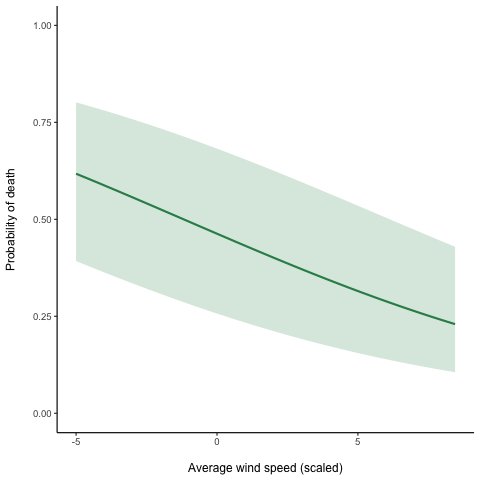

In [67]:
%%R
p <- ggplot(new_data, aes(x = wspd_average_sc, y = plogis(fit))) +
        geom_line(color = "seagreen", linewidth = 1) +
        geom_ribbon(
           aes(ymin = plogis(ci_lower), ymax = plogis(ci_upper)),
           alpha = 0.2,
           fill = "seagreen"
        ) +
        scale_y_continuous(breaks = seq(0,1,0.25), limits = c(0,1)) +
        labs(x = "\nAverage wind speed (scaled)", y = "Probability of death\n") +
        theme_classic(base_size = 12) +
        theme(panel.grid = element_blank())
p

#### Investigate extreme observations

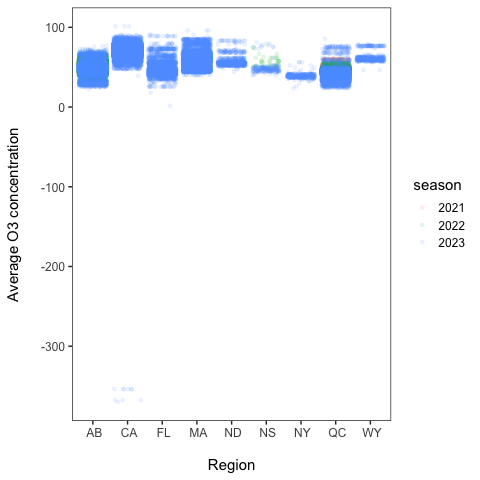

In [68]:
%%R
ggplot(data = data, aes(x = region, y = o3_average, colour = season))+
    geom_jitter(alpha = 0.1) +
    ylab("Average O3 concentration\n") +
    xlab("\nRegion") +
    theme_bw(base_size = 15) +
    theme(panel.grid = element_blank())

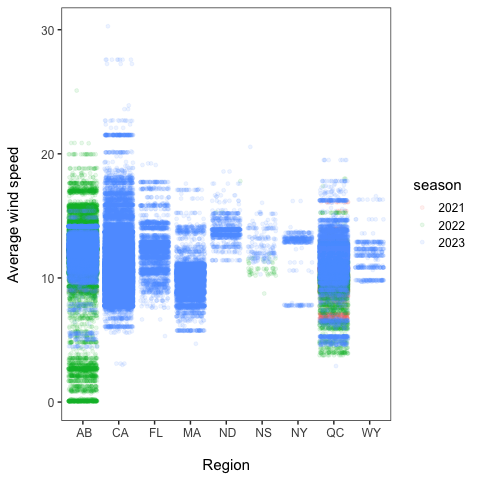

In [69]:
%%R
ggplot(data = data, aes(x = region, y = wspd_average_og, colour = season))+
    geom_jitter(alpha = 0.1) +
    ylab("Average wind speed\n") +
    xlab("\nRegion") +
    theme_bw(base_size = 15) +
    theme(panel.grid = element_blank())

Extreme observations come from : 

- California in 2023 (~10)

Will remove them from the analysis

### REFIT MODEL

We refit the model without the extremes in California and Alberta

#### Remove extreme observations

In [70]:
%%R
filtered_data <- data[data$o3_average >=0, ]

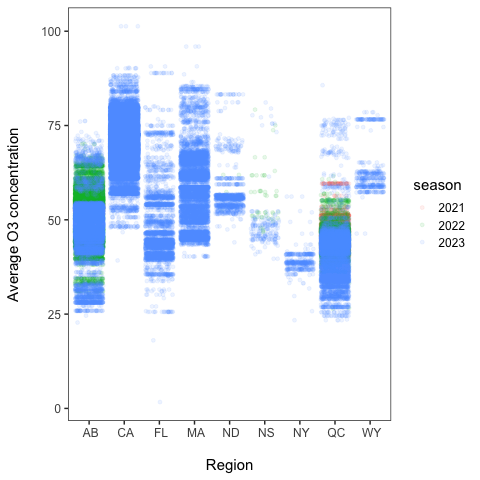

In [71]:
%%R
ggplot(data = filtered_data, aes(x = region, y = o3_average, colour = season)) +
    geom_jitter(alpha = 0.1) +
    ylab("Average O3 concentration\n") +
    xlab("\nRegion") +
    theme_bw(base_size = 15) +
    theme(panel.grid = element_blank())

#### Rescale variables

In [72]:
%%R
filtered_data$ndvi_average_sc <- scale(filtered_data$ndvi_average)
filtered_data$o3_average_sc <- scale(filtered_data$o3_average)
filtered_data$wspd_average_sc <- scale(filtered_data$wspd_average_og)

#### Fit model on filtered data

In [73]:
%%R
# Update model with filtered data
refit_model <- glmer(
    formula = form,
    family = "binomial",
    data = filtered_data
)

# Save the output
filename <- file.path("..", "outputs", "GLMM_best_model_refit.rds")
saveRDS(refit_model, filename)

In [12]:
%%R
summary(refit_model)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
death_next_season ~ ndvi_average_sc * o3_average_sc * wspd_average_sc +  
    (o3_average_sc | operation_id)
   Data: filtered_data

     AIC      BIC   logLik deviance df.resid 
128851.3 128957.3 -64414.7 128829.3   112604 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
 -8.35  -0.69  -0.46   0.85 528.87 

Random effects:
 Groups       Name          Variance Std.Dev. Corr
 operation_id (Intercept)   3.518    1.876        
              o3_average_sc 3.502    1.871    0.69
Number of obs: 112615, groups:  operation_id, 17

Fixed effects:
                                               Estimate Std. Error z value
(Intercept)                                   -0.173385   0.453871  -0.382
ndvi_average_sc                               -0.412526   0.009980 -41.334
o3_average_sc                                  1.174983   0.451978   2.600
wspd_average_sc

Odds ratio for each coefficient

In [102]:
%%R
exp(fixef(refit_model))

                                  (Intercept) 
                                    0.8408141 
                              ndvi_average_sc 
                                    0.6619762 
                                o3_average_sc 
                                    3.2380872 
                              wspd_average_sc 
                                    0.9241129 
                ndvi_average_sc:o3_average_sc 
                                    0.8789148 
              ndvi_average_sc:wspd_average_sc 
                                    0.9822836 
                o3_average_sc:wspd_average_sc 
                                    0.9474856 
ndvi_average_sc:o3_average_sc:wspd_average_sc 
                                    0.9659930 


### ASSESS MODEL FIT

In [13]:
%%R
r2_refit <- r2_nakagawa(refit_model)

In [14]:
%%R
r2_refit

# R2 for Mixed Models

  Conditional R2: 0.729
     Marginal R2: 0.151


### PLOT REFIT MODEL

#### Plot mean O3

In [74]:
%%R
# New data for predictions
new_data1 <- data.frame(
    o3_average_sc = seq(
        min(filtered_data$o3_average_sc),
        max(filtered_data$o3_average_sc),
        length.out = 100
    ),
    ndvi_average_sc = mean(filtered_data$ndvi_average_sc),
    wspd_average_sc = mean(filtered_data$wspd_average_sc)
)

# Predictions
preds <- predict(
    refit_model,
    new_data1,
    re.form = NA,
    se.fit = TRUE
)

new_data1$fit <- preds$fit
new_data1$se <- preds$se.fit
new_data1$ci_lower <- new_data1$fit - 1.96 * new_data1$se
new_data1$ci_upper <- new_data1$fit + 1.96 * new_data1$se

In addition: Warning message:
In predict.merMod(refit_model, new_data1, re.form = NA, se.fit = TRUE) :
  se.fit computation uses an approximation to estimate the sampling distribution of the parameters


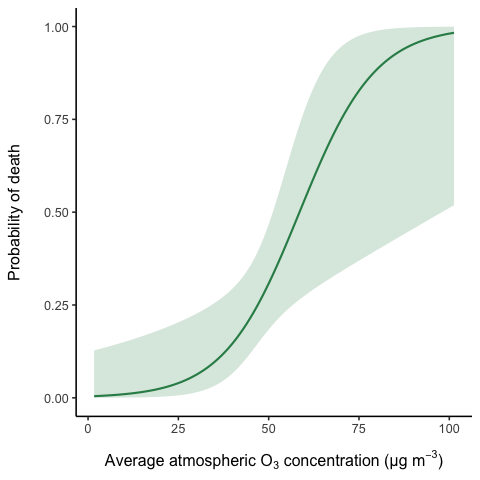

In [85]:
%%R

# Get the mean and standard deviation of o3
o3_mean <- mean(filtered_data$o3_average, na.rm = TRUE)
o3_sd <- sd(filtered_data$o3_average, na.rm = TRUE)

# Convert the o3 back to original scale
new_data1$o3_average <- (new_data1$o3_average_sc * o3_sd) + o3_mean

p1 <- ggplot(new_data1, aes(x = o3_average, y = plogis(fit))) +
        geom_line(color = "seagreen", linewidth = 1) +
        geom_ribbon(
           aes(ymin = plogis(ci_lower), ymax = plogis(ci_upper)),
           alpha = 0.2,
           fill = "seagreen"
        ) +
        scale_y_continuous(breaks = seq(0,1,0.25), limits = c(0,1)) +
        labs(
           x = expression("Average atmospheric O"[3] * " concentration (µg m"^-3*")"),
           #x = expression("Average atmospheric O"[3] * " concentration (scaled)"),
           y = "Probability of death\n"
        ) +
        theme_classic(base_size = 16) +
        theme(
         panel.grid = element_blank(),
         axis.title.x = element_text(margin = margin(t = 14))
        )
p1

### Plot mean ndvi

In [76]:
%%R
# New data for predictions
new_data2 <- data.frame(
    ndvi_average_sc = seq(
        min(filtered_data$ndvi_average_sc),
        max(filtered_data$ndvi_average_sc),
        length.out = 100
    ),
    o3_average_sc = mean(filtered_data$o3_average_sc),
    wspd_average_sc = mean(filtered_data$wspd_average_sc)
)

# Predictions
preds <- predict(
    refit_model,
    new_data2,
    re.form = NA,
    se.fit = TRUE
)

new_data2$fit <- preds$fit
new_data2$se <- preds$se.fit
new_data2$ci_lower <- new_data2$fit - 1.96 * new_data2$se
new_data2$ci_upper <- new_data2$fit + 1.96 * new_data2$se

In addition: Warning message:
In predict.merMod(refit_model, new_data2, re.form = NA, se.fit = TRUE) :
  se.fit computation uses an approximation to estimate the sampling distribution of the parameters


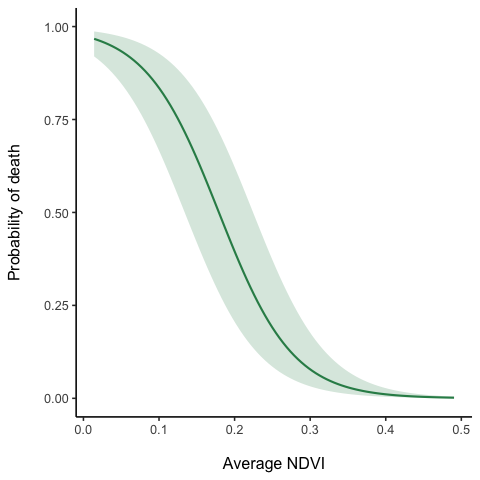

In [84]:
%%R

# Get the mean and standard deviation of ndvi
ndvi_mean <- mean(filtered_data$ndvi_average, na.rm = TRUE)
ndvi_sd <- sd(filtered_data$ndvi_average, na.rm = TRUE)

# Convert ndvi back to the original scale
new_data2$ndvi_average <- (new_data2$ndvi_average_sc * ndvi_sd) + ndvi_mean

p2 <- ggplot(new_data2, aes(x = ndvi_average, y = plogis(fit))) +
        geom_line(color = "seagreen", linewidth = 1) +
        geom_ribbon(
           aes(ymin = plogis(ci_lower), ymax = plogis(ci_upper)),
           alpha = 0.2,
           fill = "seagreen"
        ) +
        scale_y_continuous(breaks = seq(0,1,0.25), limits = c(0,1)) +
        labs(x = "\nAverage NDVI", y = "Probability of death\n") +
        theme_classic(base_size = 16) +
        theme(panel.grid = element_blank())
p2

### Plot mean wind speed

In [79]:
%%R
# New data for predictions
new_data3 <- data.frame(
    wspd_average_sc = seq(
        min(filtered_data$wspd_average_sc),
        max(filtered_data$wspd_average_sc),
        length.out = 100
    ),
    o3_average_sc = mean(filtered_data$o3_average_sc),
    ndvi_average_sc = mean(filtered_data$ndvi_average_sc)
)

# Predictions
preds <- predict(
    refit_model,
    new_data3,
    re.form = NA,
    se.fit = TRUE
)

new_data3$fit <- preds$fit
new_data3$se <- preds$se.fit
new_data3$ci_lower <- new_data3$fit - 1.96 * new_data3$se
new_data3$ci_upper <- new_data3$fit + 1.96 * new_data3$se

In addition: Warning message:
In predict.merMod(refit_model, new_data3, re.form = NA, se.fit = TRUE) :
  se.fit computation uses an approximation to estimate the sampling distribution of the parameters


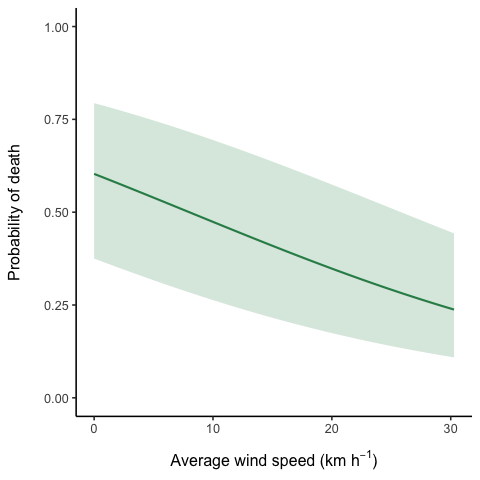

In [142]:
%%R

# Get the original mean and standard deviation of wind speed
wspd_mean <- mean(filtered_data$wspd_average_og, na.rm = TRUE)
wspd_sd <- sd(filtered_data$wspd_average_og, na.rm = TRUE)

# Convert wind speed to original scale
new_data3$wspd_average <- (new_data3$wspd_average_sc * wspd_sd) + wspd_mean

p3 <- ggplot(new_data3, aes(x = wspd_average, y = plogis(fit))) +
        geom_line(color = "seagreen", linewidth = 1) +
        geom_ribbon(
           aes(ymin = plogis(ci_lower), ymax = plogis(ci_upper)),
           alpha = 0.2,
           fill = "seagreen"
        ) +
        scale_y_continuous(breaks = seq(0,1,0.25), limits = c(0,1)) +
        labs(
           #x = "\nAverage wind speed (scaled)",
           x = expression("Average wind speed (km h"^-1*")"),
           y = "Probability of death\n"
        ) +
        theme_classic(base_size = 16) +
        theme(
         panel.grid = element_blank(),
         axis.title.x = element_text(margin = margin(t = 14))
        )
p3

#### Plot interaction

In addition: Warning message:
In predict.merMod(refit_model, newdata = grid_data, re.form = NA,  :
  se.fit computation uses an approximation to estimate the sampling distribution of the parameters


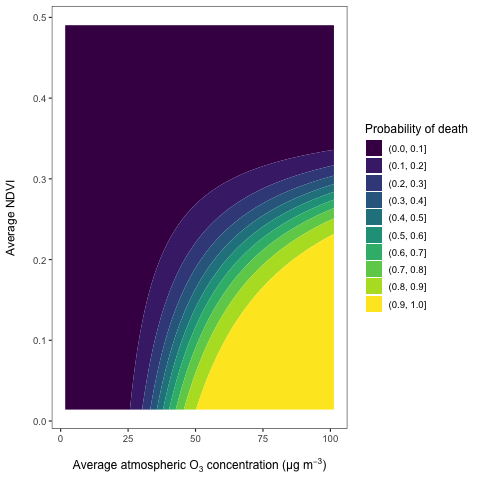

In [98]:
%%R
# Create a grid of o3_average and ndvi_average values
o3_seq <- seq(
  min(filtered_data$o3_average_sc, na.rm = TRUE),
  max(filtered_data$o3_average_sc, na.rm = TRUE),
  length.out = 100
)

ndvi_seq <- seq(
  min(filtered_data$ndvi_average_sc, na.rm = TRUE),
  max(filtered_data$ndvi_average_sc, na.rm = TRUE),
  length.out = 100
)


# Create a data frame with all combinations of o3 and ndvi
grid_data <- expand.grid(
  o3_average_sc = o3_seq,
  ndvi_average_sc = ndvi_seq,
  wspd_average_sc = mean(filtered_data$wspd_average_sc, na.rm = TRUE)
)

# Generate predictions based on the grid
grid_predictions <- predict(
    refit_model,
    newdata = grid_data,
    re.form = NA,
    se.fit = TRUE
)

# Add predictions to the grid data
grid_data$predicted <- plogis(grid_predictions$fit)


# Get the original means and standard deviations
o3_mean <- mean(filtered_data$o3_average, na.rm = TRUE)
o3_sd <- sd(filtered_data$o3_average, na.rm = TRUE)

ndvi_mean <- mean(filtered_data$ndvi_average, na.rm = TRUE)
ndvi_sd <- sd(filtered_data$ndvi_average, na.rm = TRUE)

# Convert the scaled values back to the original scale
grid_data$o3_average <- (grid_data$o3_average_sc * o3_sd) + o3_mean
grid_data$ndvi_average <- (grid_data$ndvi_average_sc * ndvi_sd) + ndvi_mean


p4 <- ggplot(grid_data, aes(x = o3_average, y = ndvi_average, z = predicted)) +
  geom_contour_filled(bins = 10) +
  labs(
    x = expression("Average atmospheric O"[3] * " concentration (µg m"^-3*")"),
    #x = expression("Average atmospheric O"[3] * " concentration (scaled)"),
    y = "Average NDVI\n",
    fill = "Probability of death"
  ) +
  theme_bw(base_size = 12) +
  theme(
    panel.grid = element_blank(),
    axis.title.x = element_text(margin = margin(t = 14))
    )
p4

Testing with raw data but not very nice

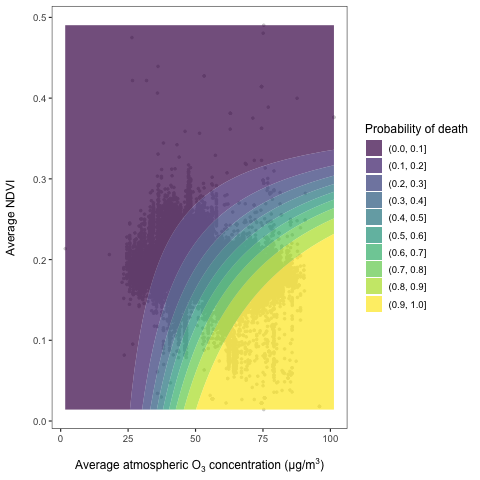

In [124]:
%%R
p5 <- ggplot() +
  geom_point(
    data = filtered_data, aes(x = o3_average, y = ndvi_average), 
    color = "lightgray", alpha = 0.99,
    shape = 20 #, size = 1.5
    ) +
  geom_contour_filled(data = grid_data, aes(x = o3_average, y = ndvi_average, z = predicted), bins = 10, alpha = 0.7) +
  labs(
    x = expression("Average atmospheric O"[3] * " concentration (µg/m"^3*")"),
    y = "Average NDVI\n",
    fill = "Probability of death"
  ) +
  theme_bw(base_size = 12) +
  theme(
    panel.grid = element_blank(),
    axis.title.x = element_text(margin = margin(t = 14))
  )
p5


In addition: Warning message:
In predict.merMod(refit_model, newdata = grid_data, re.form = NA,  :
  se.fit computation uses an approximation to estimate the sampling distribution of the parameters


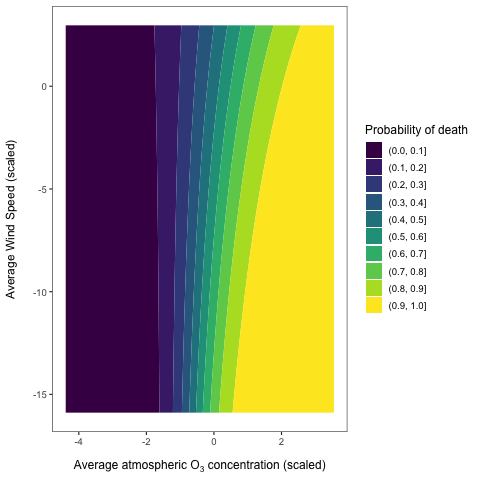

In [118]:
%%R
# Create a sequence for o3_average_sc and wspd_average_sc
o3_seq <- seq(
  min(filtered_data$o3_average_sc, na.rm = TRUE),
  max(filtered_data$o3_average_sc, na.rm = TRUE),
  length.out = 100
)

wspd_seq <- seq(
  min(filtered_data$wspd_average_sc, na.rm = TRUE),
  max(filtered_data$wspd_average_sc, na.rm = TRUE),
  length.out = 100
)

# Create a data frame with combinations of o3 and wspd
grid_data <- expand.grid(
  o3_average_sc = o3_seq,
  wspd_average_sc = wspd_seq,
  ndvi_average_sc = mean(filtered_data$ndvi_average_sc, na.rm = TRUE)
)

# Generate predictions based on the grid
grid_predictions <- predict(
    refit_model,
    newdata = grid_data,
    re.form = NA,
    se.fit = TRUE
)

# Add predictions to the grid data
grid_data$predicted <- plogis(grid_predictions$fit)

# Plot the interaction between o3_average_sc and wspd_average_sc
p_interaction <- ggplot(grid_data, aes(x = o3_average_sc, y = wspd_average_sc, z = predicted)) +
  geom_contour_filled(bins = 10) +
  labs(
    x = expression("Average atmospheric O"[3] * " concentration (scaled)"),
    y = "Average Wind Speed (scaled)\n",
    fill = "Probability of death"
  ) +
  theme_bw(base_size = 12) +
  theme(
    panel.grid = element_blank(),
    axis.title.x = element_text(margin = margin(t = 14))
  )

# Show the plot
p_interaction


TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


In addition: Warning messages:
1: In predict.merMod(refit_model, newdata = grid_data_low_wspd, re.form = NA,  :
  se.fit computation uses an approximation to estimate the sampling distribution of the parameters
2: In predict.merMod(refit_model, newdata = grid_data_high_wspd, re.form = NA,  :
  se.fit computation uses an approximation to estimate the sampling distribution of the parameters


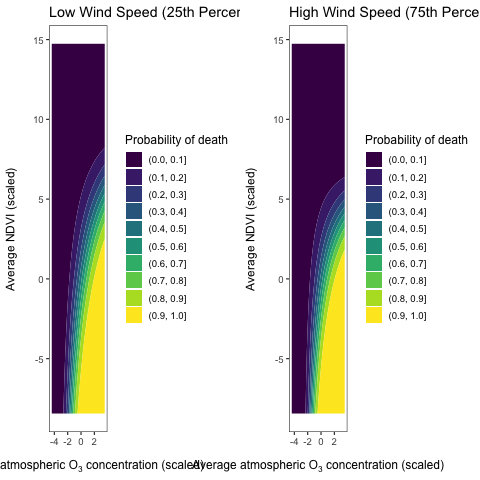

In [138]:
%%R
# Define lower and higher levels for wind speed
low_wspd <- quantile(filtered_data$wspd_average_sc, 0.25, na.rm = TRUE)  # 25th percentile (low wind speed)
high_wspd <- quantile(filtered_data$wspd_average_sc, 0.75, na.rm = TRUE) # 75th percentile (high wind speed)

# Create grid data for lower wind speed
grid_data_low_wspd <- expand.grid(
  o3_average_sc = o3_seq,
  ndvi_average_sc = ndvi_seq,
  wspd_average_sc = low_wspd
)

# Create grid data for higher wind speed
grid_data_high_wspd <- expand.grid(
  o3_average_sc = o3_seq,
  ndvi_average_sc = ndvi_seq,
  wspd_average_sc = high_wspd
)

# Generate predictions for low wind speed
grid_predictions_low_wspd <- predict(
    refit_model,
    newdata = grid_data_low_wspd,
    re.form = NA,
    se.fit = TRUE
)
grid_data_low_wspd$predicted <- plogis(grid_predictions_low_wspd$fit)

# Generate predictions for high wind speed
grid_predictions_high_wspd <- predict(
    refit_model,
    newdata = grid_data_high_wspd,
    re.form = NA,
    se.fit = TRUE
)
grid_data_high_wspd$predicted <- plogis(grid_predictions_high_wspd$fit)

# Plot for low wind speed
p_low <- ggplot(grid_data_low_wspd, aes(x = o3_average_sc, y = ndvi_average_sc, z = predicted)) +
  geom_contour_filled(bins = 10) +
  labs(
    x = expression("Average atmospheric O"[3] * " concentration (scaled)"),
    y = "Average NDVI (scaled)\n",
    fill = "Probability of death",
    title = "Low Wind Speed (25th Percentile)"
  ) +
  theme_bw(base_size = 12) +
  theme(
    panel.grid = element_blank(),
    axis.title.x = element_text(margin = margin(t = 14))
  )

# Plot for high wind speed
p_high <- ggplot(grid_data_high_wspd, aes(x = o3_average_sc, y = ndvi_average_sc, z = predicted)) +
  geom_contour_filled(bins = 10) +
  labs(
    x = expression("Average atmospheric O"[3] * " concentration (scaled)"),
    y = "Average NDVI (scaled)\n",
    fill = "Probability of death",
    title = "High Wind Speed (75th Percentile)"
  ) +
  theme_bw(base_size = 12) +
  theme(
    panel.grid = element_blank(),
    axis.title.x = element_text(margin = margin(t = 14))
  )

# Display both plots side by side
library(gridExtra)
test <- grid.arrange(p_low, p_high, ncol = 2)
#ggsave("combined_interaction_plot.png", plot = test, width = 12, height = 6)
test

#### Plot random slopes

Step 1)
- Extract fixed effects (intercept and slope)
- Extract random effects (random intercepts and slopes for each operation_id)
- Create a sequence of O3 values

Step 2)
- loop through data frame to compute predictions for each operation id
- extract random effects per operation id (deviations)
- compute total effect using fixed effects
- store in dataset

Step 3)
- compute predictions for fixed effect
- store in dataset

Step 4)
- Plot

Plot for all without regions

In [127]:
%%R

# Step 1) ------------------------------------------------------

# Extract fixed and random effects
fixed_effects <- fixef(refit_model) 
random_effects <- ranef(refit_model)$operation_id 

# Create a sequence for o3
o3_seq <- seq(min(filtered_data$o3_average_sc), max(filtered_data$o3_average_sc), length.out = 100)

# Get the original mean and standard deviation
o3_mean <- mean(filtered_data$o3_average, na.rm = TRUE)
o3_sd <- sd(filtered_data$o3_average, na.rm = TRUE)

# Unscale
o3_seq_unscaled <- (o3_seq * o3_sd) + o3_mean 



# Step 2) ------------------------------------------------------

# Empty data frame to store predictions
predictions_data <- data.frame()

# Loop through each operation_id
for (op_id in rownames(random_effects)) {
  
  # Random intercept and slope for given operation_id
  random_intercept <- random_effects[op_id, "(Intercept)"]
  random_slope <- random_effects[op_id, "o3_average_sc"]
  
  # Calculate total intercept and slope (fixed + random)
  total_intercept <- fixed_effects["(Intercept)"] + random_intercept
  total_slope <- fixed_effects["o3_average_sc"] + random_slope
  
  # Create predicted values for the given operation_id
  predicted_values <- total_intercept + total_slope * o3_seq
  
  # Store predictions for each operation id
  temp_df <- data.frame(
    o3_average = o3_seq_unscaled,
    predicted = plogis(predicted_values),  # Back-transform to probability using plogis
    operation_id = op_id
  )
  
  # Append to predictions_data
  predictions_data <- rbind(predictions_data, temp_df)
}

# Merge to add region
#predictions_data <- merge(
#  predictions_data,
#  filtered_data[, c("operation_id", "region")],
#  by = "operation_id",
#  all.x = TRUE
#)


# Step 3) ------------------------------------------------------

# Calculate the global trend (fixed effects only)
global_trend <- data.frame(
  o3_average = o3_seq_unscaled,
  predicted = plogis(fixed_effects["(Intercept)"] + fixed_effects["o3_average_sc"] * o3_seq)
)

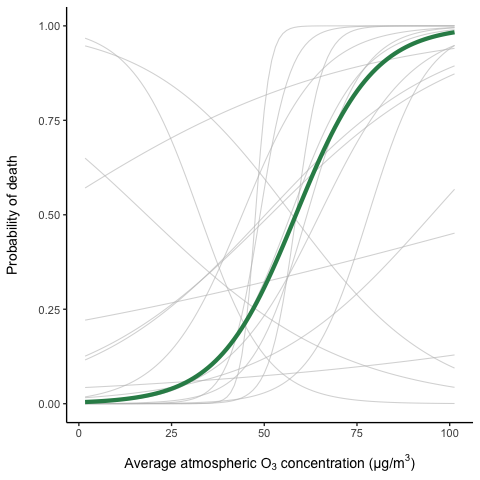

In [140]:
%%R
# Step 3) ------------------------------------------------------

p6 <- ggplot() +
  geom_line(
    data = predictions_data,
    aes(x = o3_average, y = predicted, group = operation_id),
    color = "gray",
    alpha = 0.6
  ) + 
  geom_line(
    data = global_trend,
    aes(x = o3_average, y = predicted),
    color = "seagreen", linewidth = 2
  ) +
  labs(
    x = expression("Average atmospheric O"[3] * " concentration (µg/m"^3*")"),
    y = "Probability of death\n") +
  theme_classic(base_size = 14) +
  theme(
    axis.title.x = element_text(margin = margin(t = 14))
  )

p6

Plot for all by region

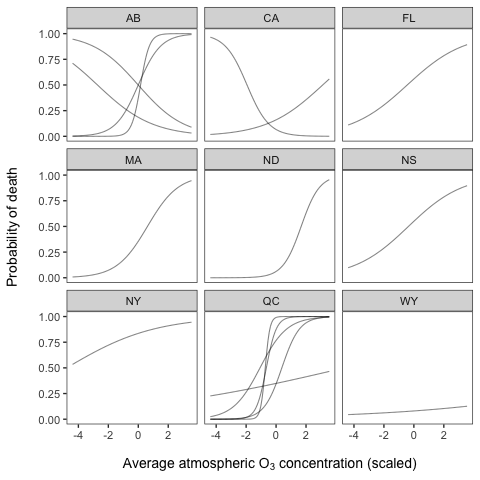

In [139]:
%%R
p7 <- ggplot(predictions_data, aes(x = o3_average, y = predicted, group = operation_id)) +
  geom_line(alpha = 0.5) +
  labs(
    x = expression("Average atmospheric O"[3] * " concentration (scaled)"),
    y = "Probability of death\n"
  ) +
  scale_y_continuous(breaks = seq(0, 1, 0.25), limits = c(0, 1)) +
  facet_wrap(~region) +
  theme_bw(base_size = 14) +
  theme(
    legend.position = "none",
    panel.grid = element_blank(),
    axis.title.x = element_text(margin = margin(t = 16))
  )
p7

In [20]:
%%R
counts_df <- aggregate(x = list(observation_count = filtered_data$region), 
                       by = list(region = filtered_data$region, operation_id = filtered_data$operation_id), 
                       FUN = length)
counts_df

   region operation_id observation_count
1      QC           55             11231
2      AB           69             28601
3      QC           83               114
4      AB           87              3827
5      AB          153              8305
6      QC          159               181
7      NS          160               238
8      QC          161              6443
9      MA          167              7073
10     ND          177              1003
11     CA          193             38473
12     WY          194               453
13     CA          195              1196
14     AB          205               194
15     FL          207              3367
16     QC          210              1491
17     NY          212               425


`geom_smooth()` using formula = 'y ~ x'


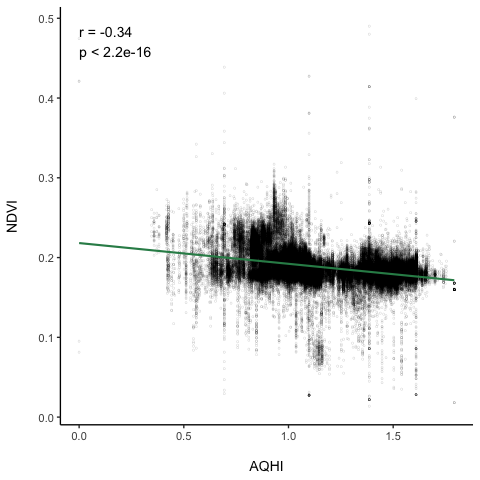

In [60]:
%%R
cor_test1 <- with(filtered_data, cor.test(aqhi_average, ndvi_average))

# Extract the estimate
correlation1 <- round(cor_test1$estimate, 2)

ggplot(data = filtered_data, aes(x = aqhi_average, y = ndvi_average)) +
    geom_point(shape = "o", alpha = 0.2) +
    geom_smooth(method = "lm", color = "seagreen") +
    labs(x = "\nAQHI", y = "NDVI\n") +
    theme_classic(base_size = 14) +
    theme(panel.grid = element_blank()) +
    annotate(
        "text", x = min(filtered_data$aqhi_average), y = max(filtered_data$ndvi_average), 
        label = paste("r =", correlation1), 
        hjust = 0, vjust = 1, size = 5, color = "black"
    ) +
    annotate(
        "text", x = min(filtered_data$aqhi_average), y = max(filtered_data$ndvi_average), 
        label = paste("p <", "2.2e-16"), 
        hjust = 0, vjust = 3, size = 5, color = "black"
    )

`geom_smooth()` using formula = 'y ~ x'


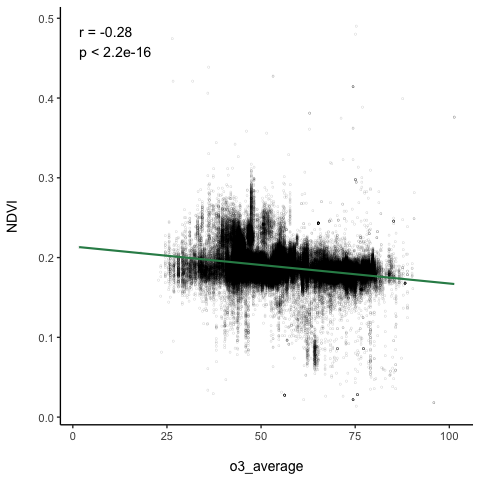

In [66]:
%%R
cor_test2 <- with(filtered_data, cor.test(o3_average, ndvi_average))

# Extract the estimate
correlation2 <- round(cor_test2$estimate, 2)

ggplot(data = filtered_data, aes(x = o3_average, y = ndvi_average)) +
    geom_point(shape = "o", alpha = 0.2) +
    geom_smooth(method = "lm", color = "seagreen") +
    labs(x = "\no3_average", y = "NDVI\n") +
    theme_classic(base_size = 14) +
    theme(panel.grid = element_blank()) +
    annotate(
        "text", x = min(filtered_data$o3_average), y = max(filtered_data$ndvi_average), 
        label = paste("r =", correlation2), 
        hjust = 0, vjust = 1, size = 5, color = "black"
    ) +
    annotate(
        "text", x = min(filtered_data$o3_average), y = max(filtered_data$ndvi_average), 
        label = paste("p <", "2.2e-16"), 
        hjust = 0, vjust = 3, size = 5, color = "black"
    )

### SAVE PLOTS

Main effects plots

In [143]:
%%R
figure <- ggarrange(
    p1, p2, p3,
    ncol = 3,
    nrow = 1
)

filename <- file.path("..", "outputs", "GLMM_MainEffects.png")
ggexport(
    figure,
    filename = filename,
    res = 270,
    width = 4600,
    height = 1400
)

file saved to ../outputs/GLMM_MainEffects.png


Interaction and random slopes

In [141]:
%%R
file_path <- file.path("..", "outputs")

ggsave(filename = file.path(file_path, "GLMM_RandomSlopes.png"), plot = p6, width = 6, height = 6)
ggsave(filename = file.path(file_path, "GLMM_InteractionEffect.png"), plot = p4, width = 6, height = 4)